Nuestro cliente nos pide que le digamos el precio al que podemos esperar vender las 3 últimas viviendas que acaban de entrar en la base de datos, y con qué margen de seguridad nos movemos.  
Para ello, nos dan los datos de las viviendas que tienen en su base de datos.

# Imports

Librerias

In [5]:
pip install catboost

In [6]:
# gestión de datos
import numpy as np
import pandas as pd

# fechas
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

Datos

In [7]:
# conexion a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# carga de los datos en un dataframe
df = pd.read_csv('/content/drive/MyDrive/TIC/Data science/Master Data Science Nuclio - profesor/Aprendizaje supervisado - Presencial/Regresion - ejemplo basico - viviendas/viviendas_regresion_basica.csv')

# Business Understanding​

In [9]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0,1.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0,1.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0,1.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0,1.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6998,viv_6999,128.0,3,5,1979-01-01,NaN,0,1.3,317000.0,31700.0,0.0
6999,viv_7000,77.0,4+,7,1996-01-01,ext,0,1.5,177000.0,17700.0,0.0
7000,viv_7001,128.0,3,6,2022-01-01,ext,0,0.7,NaN,NaN,NaN
7001,viv_7002,93.0,4+,9,1988-01-01,NaN,0,1.5,NaN,NaN,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7003 entries, 0 to 7002
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_vivienda  7003 non-null   object 
 1   superficie   6993 non-null   float64
 2   num_hab      7003 non-null   object 
 3   distancia    7003 non-null   int64  
 4   fecha_const  7003 non-null   object 
 5   parking      4764 non-null   object 
 6   premiada     7003 non-null   int64  
 7   tam_buzon    7003 non-null   float64
 8   precio       7000 non-null   float64
 9   impuestos    7000 non-null   float64
 10  vendida      7000 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 601.9+ KB


In [11]:
df_predecir = df[df['precio'].isnull()]
df_predecir

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
7000,viv_7001,128.0,3,6,2022-01-01,ext,0,0.7,NaN,NaN,NaN
7001,viv_7002,93.0,4+,9,1988-01-01,NaN,0,1.5,NaN,NaN,NaN
7002,viv_7003,68.0,2,3,1972-01-01,NaN,0,0.7,NaN,NaN,NaN


In [12]:
# quitamos las 3 viviendas a predecir
df = df[df['precio'].isnull() == False]
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0,1.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0,1.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0,1.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0,1.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6995,viv_6996,98.0,2,2,2006-01-01,int,0,1.8,342000.0,34200.0,0.0
6996,viv_6997,111.0,4+,2,1981-01-01,ext,0,0.9,121000.0,12100.0,0.0
6997,viv_6998,76.0,3,4,2009-01-01,ext,0,0.6,250000.0,25000.0,0.0
6998,viv_6999,128.0,3,5,1979-01-01,NaN,0,1.3,317000.0,31700.0,0.0


In [13]:
# quitamos las viviendas que no se han vendido
df = df[df['vendida']==1]
df = df.drop('vendida', axis=1)
df_predecir = df_predecir.drop('vendida', axis=1)

In [14]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0
...,...,...,...,...,...,...,...,...,...,...
6987,viv_6988,130.0,3,7,1996-01-01,NaN,0,1.9,286000.0,28600.0
6988,viv_6989,120.0,3,8,2022-01-01,ext,0,1.0,299000.0,29900.0
6989,viv_6990,76.0,4+,7,2006-01-01,ext,0,0.5,245000.0,24500.0
6992,viv_6993,128.0,3,8,2022-01-01,NaN,0,1.3,276000.0,27600.0


In [15]:
df_predecir = df_predecir.drop('precio', axis=1)

# Análisis exploratorio

In [16]:
df.nunique()

id_vivienda    5000
superficie       71
num_hab           4
distancia        10
fecha_const      60
parking           2
premiada          2
tam_buzon        16
precio          217
impuestos       217
dtype: int64

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
superficie,4990.0,96.931663,20.044797,60.0,80.0,98.0,114.0,130.0
distancia,5000.0,5.410600,2.786245,1.0,3.0,5.0,8.0,10.0
premiada,5000.0,0.000200,0.014142,0.0,0.0,0.0,0.0,1.0
tam_buzon,5000.0,1.243360,0.432117,0.5,0.9,1.2,1.6,2.0
precio,5000.0,245552.600000,47504.380498,129000.0,209000.0,243000.0,282000.0,350000.0
impuestos,5000.0,24555.260000,4750.438050,12900.0,20900.0,24300.0,28200.0,35000.0


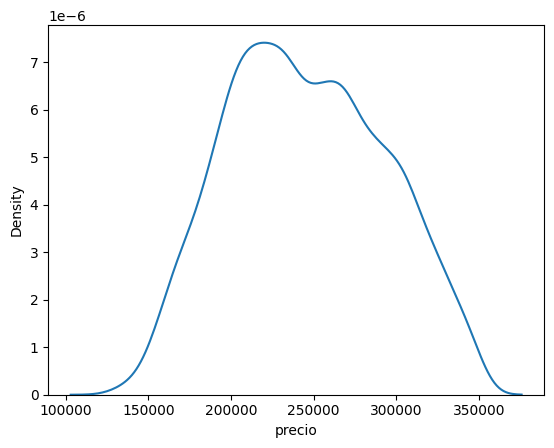

In [18]:
sns.kdeplot(data=df, x='precio')
plt.show()

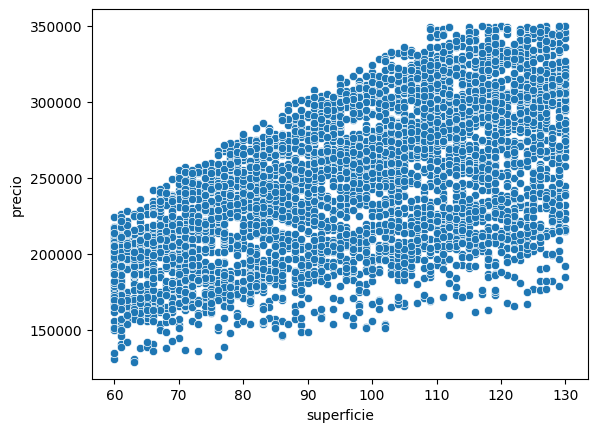

In [19]:
sns.scatterplot(data=df, x='superficie', y='precio')
plt.show()

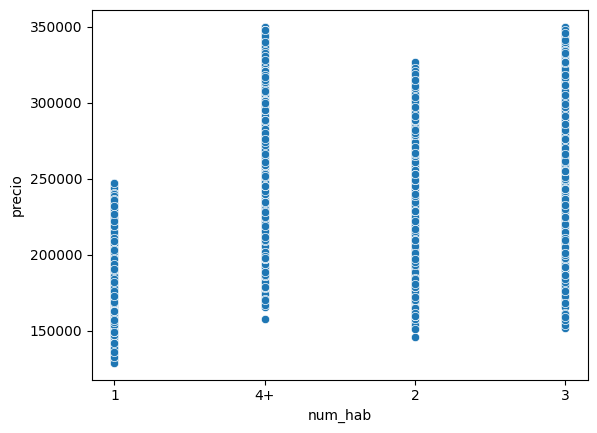

In [20]:
sns.scatterplot(data=df, x='num_hab', y='precio')
plt.show()

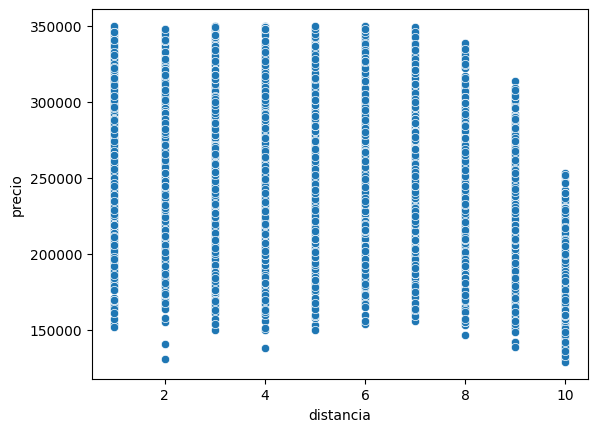

In [21]:
sns.scatterplot(data=df, x='distancia', y='precio')
plt.show()

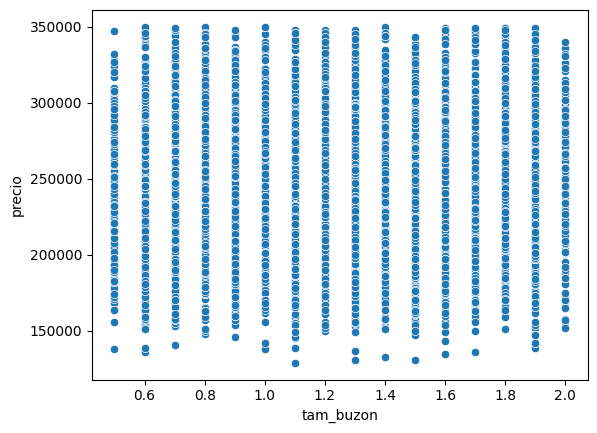

In [22]:
sns.scatterplot(data=df, x='tam_buzon', y='precio')
plt.show()

# Preprocessing

## data cleaning

In [23]:
# comprobamos duplicados
df.duplicated().sum()

0

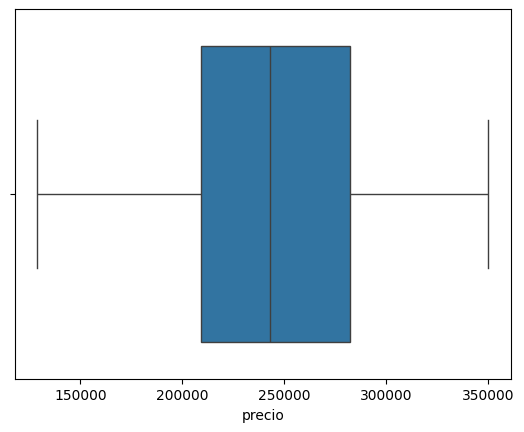

In [24]:
# comprobamos outliers
sns.boxplot(data=df, x='precio')
plt.show()

## gestión de los nulos

In [25]:
df.isnull().sum()

id_vivienda       0
superficie       10
num_hab           0
distancia         0
fecha_const       0
parking        1580
premiada          0
tam_buzon         0
precio            0
impuestos         0
dtype: int64

parking

In [26]:
df['parking'].unique()

array(['ext', nan, 'int'], dtype=object)

In [27]:
df['parking'].value_counts()

parking
ext    1748
int    1672
Name: count, dtype: int64

Interpretamos el nulo en la columna parking como la ausencia de parking en la vivienda, no como la ausencia de datos.  
Imputaremos el valor 'sin'.

In [28]:
df['parking'] = df['parking'].fillna('sin')
df_predecir['parking'] = df_predecir['parking'].fillna('sin')

superficie

Solo son 10 viviendas sin datos: los eliminamos.

In [29]:
df = df.dropna()

In [30]:
df.isnull().sum().sum()

0

## gestión de las variables categóricas

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4990 entries, 0 to 6994
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_vivienda  4990 non-null   object 
 1   superficie   4990 non-null   float64
 2   num_hab      4990 non-null   object 
 3   distancia    4990 non-null   int64  
 4   fecha_const  4990 non-null   object 
 5   parking      4990 non-null   object 
 6   premiada     4990 non-null   int64  
 7   tam_buzon    4990 non-null   float64
 8   precio       4990 non-null   float64
 9   impuestos    4990 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 428.8+ KB


### id_vivienda

In [32]:
df = df.drop('id_vivienda', axis=1)

id_viv_predecir = df_predecir['id_vivienda']
df_predecir = df_predecir.drop('id_vivienda', axis=1)

### superficie



In [33]:
df['superficie'] = df['superficie'].astype('int64')
df_predecir['superficie'] = df_predecir['superficie'].astype('int64')

### num_hab

In [34]:
df['num_hab'].unique()

array(['1', '4+', '2', '3'], dtype=object)

-> Vamos a cambiar el '4+' por 4

In [35]:
df['num_hab'] = df['num_hab'].apply(lambda x: 4 if x == '4+' else int(x))
df_predecir['num_hab'] = df_predecir['num_hab'].apply(lambda x: 4 if x == '4+' else int(x))

### fecha_const

-> vamos a cambiar la fecha de construcción por la edad en años

In [36]:
# pasamos la variable a formato de fecha
df['fecha_const'] = pd.to_datetime(df['fecha_const'])
df_predecir['fecha_const'] = pd.to_datetime(df_predecir['fecha_const'])

In [37]:
# creamos la variable hoy con tipo de objeto de fechas de pandas: timestamp
hoy = pd.Timestamp(dt.date.today())
hoy

Timestamp('2024-05-17 00:00:00')

In [38]:
# calculamos la edad en dias
df['edad'] = hoy - df['fecha_const']
df_predecir['edad'] = hoy - df_predecir['fecha_const']

In [39]:
# extraemos el numero de dias de la edad para quedarnos con un tipo de variable númerica
df['edad'] = df['edad'].dt.days
df_predecir['edad'] = df_predecir['edad'].dt.days

In [40]:
# pasamos la edad a años
df['edad'] = df['edad'] / 365
df_predecir['edad'] = df_predecir['edad'] / 365

In [41]:
# redondeamos
df['edad'] = df['edad'].round(0)
df_predecir['edad'] = df_predecir['edad'].round(0)

In [42]:
# cambiamos el tipo a integer
df['edad'] = df['edad'].astype('int64')
df_predecir['edad'] = df_predecir['edad'].astype('int64')

In [43]:
# eliminamos la variable fecha_const
df = df.drop('fecha_const', axis=1)
df_predecir = df_predecir.drop('fecha_const', axis=1)

### parking

In [44]:
df['parking'].value_counts()

parking
ext    1742
int    1668
sin    1580
Name: count, dtype: int64

-> se tratará con one hot encoding: crea una columna booleana por cada categoría

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4990 entries, 0 to 6994
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   superficie  4990 non-null   int64  
 1   num_hab     4990 non-null   int64  
 2   distancia   4990 non-null   int64  
 3   parking     4990 non-null   object 
 4   premiada    4990 non-null   int64  
 5   tam_buzon   4990 non-null   float64
 6   precio      4990 non-null   float64
 7   impuestos   4990 non-null   float64
 8   edad        4990 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 389.8+ KB


In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
superficie,4990.0,96.931663,20.044797,60.0,80.0,98.0,114.0,130.0
num_hab,4990.0,2.605411,1.075805,1.0,2.0,3.0,4.0,4.0
distancia,4990.0,5.408417,2.786865,1.0,3.0,5.0,8.0,10.0
premiada,4990.0,0.000200,0.014156,0.0,0.0,0.0,0.0,1.0
tam_buzon,4990.0,1.243507,0.431958,0.5,0.9,1.2,1.6,2.0
precio,4990.0,245515.230461,47513.575494,129000.0,209000.0,243000.0,282000.0,350000.0
impuestos,4990.0,24551.523046,4751.357549,12900.0,20900.0,24300.0,28200.0,35000.0
edad,4990.0,30.173547,17.166837,1.0,15.0,30.0,45.0,60.0
